<a href="https://colab.research.google.com/github/YuriySamorodov/MIPT/blob/main/%D0%A1%D0%B5%D0%BC%D0%B5%D1%81%D1%82%D1%80%202/%D0%9E%D1%81%D0%BD%D0%BE%D0%B2%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE%20%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F/HW_Extra/hw_additional_yuriy_samorodov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Дополнительное домашнее задание. Логистическая регрессия и решающие деревья**

Суммарно 10 баллов за всю работу. По 5 баллов в каждой части.

Требуется выполнить следующие задания.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random

from __future__ import annotations

## **Часть 1. Логистическая регрессия (5 баллов)**

**Задание 1 (3 балла)**. Реализуйте логистическую регрессию, обучаемую с помощью двух видов градиенткого спуска:
- полный (по всем данным) градиентный спуск;

- стохастический градиентный спуск;

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска.
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка 1e-6), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавьте атрибут класса `loss_history`. В нем после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

In [2]:
from sklearn.base import BaseEstimator

from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc

from sklearn.model_selection import KFold

In [3]:
from sklearn.base import BaseEstimator

from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc

from sklearn.model_selection import KFold

class MyLogisticRegression(BaseEstimator):
    def __init__(self, gd_type: str = 'stochastic', tolerance: float = 1e-6,
                 max_iter: int = 1000, eta: float = 1e-2,
                 w0: np.array = None) -> None:
        """
        Аргументы:
          gd_type: вид градиентного спуска ('full' или 'stochastic').

          tolerance: порог для остановки градиетного спуска.

          max_iter: максимальное количество шагов в градиентном спуске.

          eta: скорость обучения (learning rate).

          w0: массив размерности d (d — количество весов в оптимизации).
              Начальные веса.
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None

    def sigmoid(self, z: np.array) -> np.array:
        """
        Вычисляет сигмоидальную функцию.
        """
        # your code
        return 1 / (1 + np.exp(-z))


    def fit(self, X: np.array, y: np.array) -> MyLogisticRegression:
        """Обучаем модель на training данных. Сохраняйте значении функции потерь после каждой итерации.

        Аргументы:
          X: данные на обучение.

          y: целевая переменная.

        Возвращает:
          self: обученный регрессор.
        """
        self.loss_history = []
        # your code
        n, d = X.shape
        if self.w0 is not None:
            self.w = self.w0.copy()
        else:
            self.w = np.zeros(d)
        for i in range(self.max_iter):
            w_old = self.w.copy()
            if self.gd_type == 'full':
                grad = self.calc_gradient(X, y)
            elif self.gd_type == 'stochastic':
                idx = np.random.randint(0, n)
                grad = self.calc_gradient(X[idx:idx+1], y[idx:idx+1])
            else:
                raise ValueError("gd_type must be 'full' or 'stochastic'")
            self.w -= self.eta * grad
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)
            if np.linalg.norm(self.w - w_old) < self.tolerance:
                break
        return self


    def predict_proba(self, X: np.array) -> np.array:
        """Вычислите вероятности положительного и отрицательного классов для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n, 2).
             Предсказанные вероятности.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        # your code
        probs = self.sigmoid(X @ self.w)
        return np.vstack([1 - probs, probs]).T


    def predict(self, X: np.array) -> np.array:
        """Предсказание метки класса для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n,).
             Предсказанные метки классов.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        # your code
        probs = self.sigmoid(X @ self.w)
        return (probs >= 0.5).astype(int)


    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Вычислите градиент функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d), n может быть равно 1, если выбран 'stochastic'.
          y: массив размером (n,).

        Возвращает:
          Массив размером (d,).
          Градиент функции потерь после текущей итерации.
        """
        # your code
        z = X @ self.w
        h = self.sigmoid(z)
        grad = X.T @ (h - y) / X.shape[0]
        return grad # Add return statement


    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Вычислите значение функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d).
          y: массив размером (n,).

        Возвращает:
          Значение функции потерь после текущей итерации.
        """
        # your code
        # Логистическая функция потерь (log-loss)
        z = X @ self.w
        h = self.sigmoid(z)
        # Для численной стабильности
        h = np.clip(h, 1e-10, 1 - 1e-10)
        loss = -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))
        return loss

Далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

Сгенерируем искусственные данные.

In [4]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=999)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=999)

**Задание 2 (1 балл).** Обучите логистическую регрессию на искусственных данных. Нарисуйте изменение лосса во время обучения.

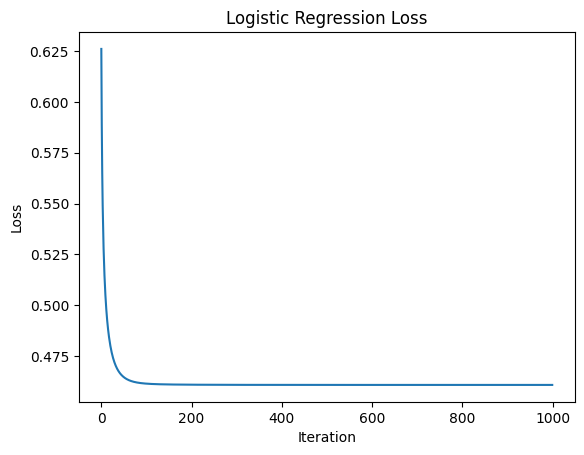

In [5]:
# your code
# Добавим bias (столбец единиц)
X_train_b = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test_b = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

model = MyLogisticRegression(gd_type='full', eta=0.1, max_iter=1000)
model.fit(X_train_b, y_train)

plt.plot(model.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Logistic Regression Loss')
plt.show()


На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC- и PR-кривые.

ROC-AUC: 0.859, PR-AUC: 0.822


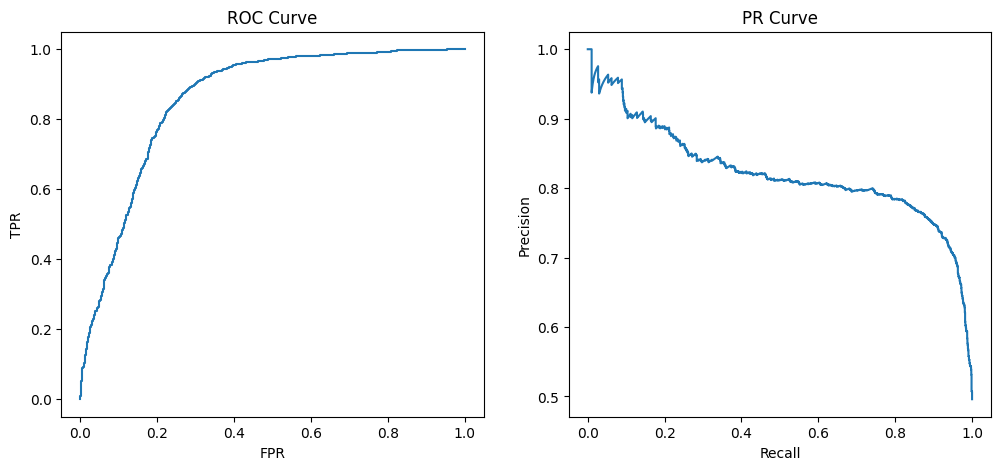

In [6]:
# your code
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc

probs = model.predict_proba(X_test_b)[:, 1]
roc_auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
pr, re, _ = precision_recall_curve(y_test, probs)
pr_auc = auc(re, pr)

print(f'ROC-AUC: {roc_auc:.3f}, PR-AUC: {pr_auc:.3f}')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

plt.subplot(1,2,2)
plt.plot(re, pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.show()


**Задание 3 (1 балл).** Оцените ошибку ROC-AUC и PR-AUC вашей модели при помощи K-fold кросс-валидации.  

In [7]:
# your code
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
roc_aucs = []
pr_aucs = []

for train_idx, test_idx in kf.split(X):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    X_tr_b = np.hstack([X_tr, np.ones((X_tr.shape[0], 1))])
    X_te_b = np.hstack([X_te, np.ones((X_te.shape[0], 1))])
    model = MyLogisticRegression(gd_type='full', eta=0.1, max_iter=1000)
    model.fit(X_tr_b, y_tr)
    probs = model.predict_proba(X_te_b)[:, 1]
    roc_aucs.append(roc_auc_score(y_te, probs))
    pr, re, _ = precision_recall_curve(y_te, probs)
    pr_aucs.append(auc(re, pr))

print(f'KFold ROC-AUC: {np.mean(roc_aucs):.3f} ± {np.std(roc_aucs):.3f}')
print(f'KFold PR-AUC: {np.mean(pr_aucs):.3f} ± {np.std(pr_aucs):.3f}')


KFold ROC-AUC: 0.861 ± 0.010
KFold PR-AUC: 0.834 ± 0.014


## **Часть 2. Решающие деревья (5 баллов)**

Здесь требуется реализовать разбиение элементов выборки в вершине дерева.

$R_m$ — множество объектов в разбиваемой вершине, $j$ — номер признака, по которому происходит разбиение, $t$ — порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ — множество объектов в левом поддереве, $R_r$ — множество объектов в правом поддереве.

$H(R)$ — критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

In [8]:
from typing import Iterable, List, Tuple

Так как Boston Dataset с недавних пор отсутствует в sklearn, то ниже реализован способ загрузки данного датасета из другого источника.

In [9]:
# `load_boston` has been removed from scikit-learn since version 1.2.

#from sklearn.datasets import load_boston
#boston = load_boston()

In [12]:
# !wget -i https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv
# Download the raw CSV file
!wget https://raw.githubusercontent.com/Samveelkhan22/Boston-Housing-Price-Prediction-Using-k-NN-Algorithm/main/BostonHousing.csv
# Inspect the first few lines of the downloaded file to confirm delimiter and structure
# !head BostonHousing.csv

# Read the CSV file with the correct separator. Based on the data description later in the notebook,
# the columns seem to be space-separated.
data_git = pd.read_csv('BostonHousing.csv', sep="\s+")

--2025-05-25 18:18:52--  https://raw.githubusercontent.com/Samveelkhan22/Boston-Housing-Price-Prediction-Using-k-NN-Algorithm/main/BostonHousing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32374 (32K) [text/plain]
Saving to: ‘BostonHousing.csv’

BostonHousing.csv   100%[===================>]  31.62K  --.-KB/s    in 0.01s   

2025-05-25 18:18:52 (2.96 MB/s) - ‘BostonHousing.csv’ saved [32374/32374]



**Data Set Characteristics:**  

    :Number of Instances: 506

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.



In [13]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [14]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

X = pd.DataFrame(data, columns=feature_names, index=range(len(data)))
y = pd.DataFrame(target, columns=['MEDV'], index=range(len(target)))

X['target'] = y

In [15]:
X_train, X_test = train_test_split(X, test_size=0.25, random_state=999)

**Задание 1 (1 балл)**. Реализуйте подсчет критерия ошибки. Для этого реализуйте функции для подсчета значения критерия информативности, а также для разбиения вершины.

In [16]:
def H(R: np.array) -> float:
    """
    Вычислить критерий информативности (impurity criterion) для фиксированного набора объектов R.
    Предполагается, что последний столбец содержить целевую переменную.
    """
    # your code
    y = R[:, -1]
    return np.var(y)


def split_node(R_m: np.array, feature: str, t: float) -> Iterable[np.array]:
    """
    Разделить фиксированный набор объектов R_m с заданным признаком (номером признака) и пороговым значением t.
    """
    # your code
    feature_idx = X_train.columns.get_loc(feature)
    left = R_m[R_m[:, feature_idx] <= t]
    right = R_m[R_m[:, feature_idx] > t]
    return left, right


def q_error(R_m: np.array, feature: str, t: float) -> float:
    """
    Вычислить критерий ошибки для заданных параметров разделения.
    """
    # your code
    left, right = split_node(R_m, feature, t)
    n = len(R_m)
    q = (len(left)/n)*H(left) + (len(right)/n)*H(right)
    return q

**Задание 2 (1 балл)**. Переберите все возможные разбиения обучающей выборки по одному из признаков и постройте график критерия ошибки в зависимости от значения порога.

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:4008: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


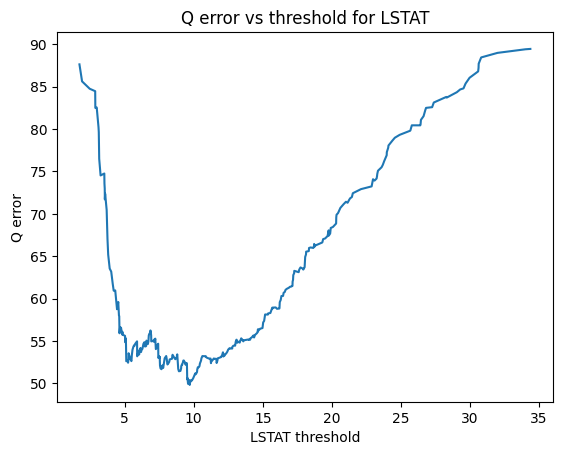

In [17]:
# your code
feature = 'LSTAT'
R_m = X_train.values
feature_idx = X_train.columns.get_loc(feature)
thresholds = np.unique(R_m[:, feature_idx])
qs = [q_error(R_m, feature, t) for t in thresholds]

plt.plot(thresholds, qs)
plt.xlabel(f'{feature} threshold')
plt.ylabel('Q error')
plt.title(f'Q error vs threshold for {feature}')
plt.show()


**Задание 3  (1 балл)**. Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку.

In [18]:
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    # your code
    feature_idx = X_train.columns.get_loc(feature)
    thresholds = np.unique(R_m[:, feature_idx])
    qs = [q_error(R_m, feature, t) for t in thresholds]
    min_idx = np.argmin(qs)
    return thresholds[min_idx], qs


**Задание 4  (1 балл)**. Для первого разбиения найдите признак, показывающий наилучшее качество. Каков порог разбиения и значение качества? Постройте график критерия ошибки для данного признака в зависимости от значения порога.

Best feature: RM, threshold: 8.78, Q error: 49.381


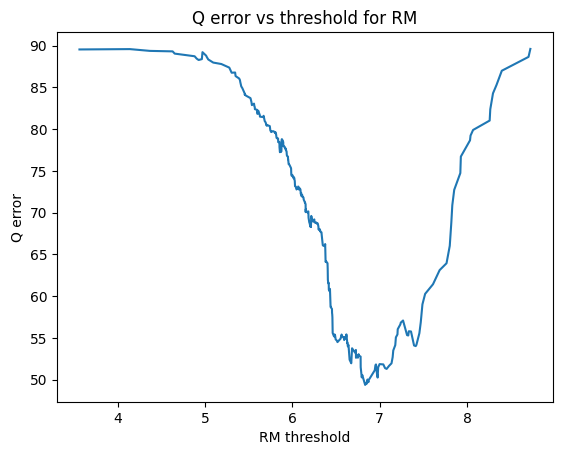

In [19]:
# your code
best_q = float('inf')
best_feature = None
best_t = None
qs_dict = {}

for feature in X_train.columns[:-1]:
    t, qs = get_optimal_split(R_m, feature)
    min_q = min(qs)
    if min_q < best_q:
        best_q = min_q
        best_feature = feature
        best_t = t
    qs_dict[feature] = qs

print(f'Best feature: {best_feature}, threshold: {best_t}, Q error: {best_q:.3f}')

# График для лучшего признака
feature_idx = X_train.columns.get_loc(best_feature)
thresholds = np.unique(R_m[:, feature_idx])
plt.plot(thresholds, qs_dict[best_feature])
plt.xlabel(f'{best_feature} threshold')
plt.ylabel('Q error')
plt.title(f'Q error vs threshold for {best_feature}')
plt.show()


 **Задание 5 (1 балл)**. Изобразите разбиение визуально. Для этого постройте диаграмму рассеяния целевой переменной в зависимости от значения входного признака. Далее изобразите вертикальную линию, соответствующую порогу разбиения.

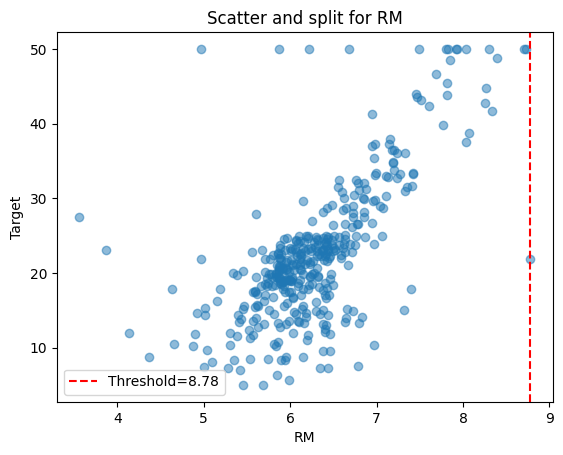

In [20]:
# your code
plt.scatter(R_m[:, feature_idx], R_m[:, -1], alpha=0.5)
plt.axvline(best_t, color='red', linestyle='--', label=f'Threshold={best_t:.2f}')
plt.xlabel(best_feature)
plt.ylabel('Target')
plt.title(f'Scatter and split for {best_feature}')
plt.legend()
plt.show()
